In [35]:
import scipy.io
import numpy as np
from statistics import mean
from statistics import variance
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt

In [116]:
arduino_data = loadmat('arduino_data.mat')
arduino_data = np.squeeze(arduino_data['data'])
arduino_data = arduino_data[10000:480000]
print(arduino_data.shape)

(470000,)


In [117]:
# Process trigger data from matlab

def mat2arr(addr, output_name):
    mat = scipy.io.loadmat(addr + '.mat')
    trigger_data = np.array(mat[output_name][0][0][1][0][0][0])
    trigger_data = trigger_data
    trigger_data = sum(trigger_data)[0]
    return trigger_data


UDP_changes = mat2arr('UDP_output', 'Trigger')

In [118]:
UDP_changes = mat2arr('UDP_output', 'Trigger')
UDP_changes = (UDP_changes[10000:480000] > 0)
print("Data array size for triggers: ", UDP_changes.shape)
print("First 10 elements: ", UDP_changes[0:10])
print("Total trials detected: ", sum(UDP_changes))

Data array size for triggers:  (470000,)
First 10 elements:  [False False False False False False False False False False]
Total trials detected:  97


In [119]:
line_boo = arduino_data > 50000;
length = arduino_data.shape[0]

changes = np.zeros((1, length));
trigger = 0;
    
for i in range(length):
    if ((line_boo[i] == 1) and (trigger == 0)):
        trigger = 1;
        changes[:, i] = 1;
    elif ((line_boo[i] == 1) and (trigger == 1)):
        trigger = 1;
    else:
        trigger = 0;

arduino_changes = (np.squeeze(changes) > 0.8)
arduino_changes[0] = 0

In [120]:
np.sum(changes)

97.0

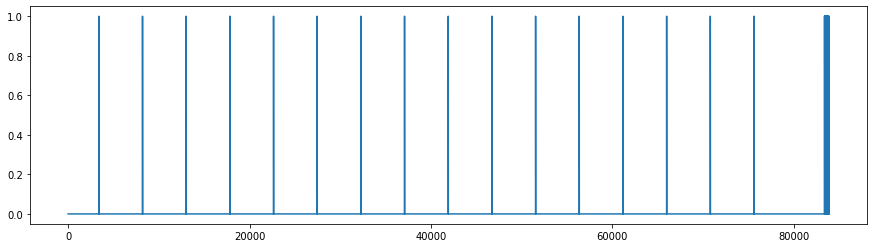

In [115]:
plt.figure(figsize=(15, 4))
plt.plot(arduino_changes[400000:])

In [82]:
# Find the times between trials
def spacing_sec(data, fs, spacing_truth_s):
    spacing = []
    spacing_sec = []
    deviations = []
    cnt = 0
    on = False
    n_trials = 0

    for i in data:
        if (i): 
            n_trials += 1
        if (i and not on):
            on = True
        elif (not i and on):
            cnt += 1
        elif (i and on):
            spacing.append(cnt)
            cnt = 0
            on = False
            
    # Convert it into seconds
    spacing_sec = [i/fs for i in spacing]
    deviations = [(i-(spacing_truth_s*fs)) for i in spacing]
    total_deviation = sum(deviations)
    max_deviation = max(deviations)
    min_deviation = min(deviations)
    
    return n_trials, spacing_sec, total_deviation, max_deviation, min_deviation, deviations

n_trials, spacing_sec, avg_dev, max_dev, min_dev, deviations = spacing_sec(trigger_data, 
                                                                 fs = 1200, 
                                                                 spacing_truth_s = 4)
fs = 1200
print("------------------------------")
print("Total trials: ", n_trials)
print("------------------------------")
# print("Spacings: ", spacing_sec)
# print("------------------------------")
print("Deviations: ", deviations)
print("------------------------------")
print("Total deviation (sec): ", round(avg_dev/fs, 5), "s")
print("Max deviation (sec): ", round(max_dev/fs, 5), "s")
print("Min deviation (sec): ", round(min_dev/fs, 5), "s")

print("------------------------------")
print("Total deviation (samples): ", round(avg_dev))
print("Max deviation (samples): ", max_dev)
print("Min deviation (samples): ", min_dev)
print("------------------------------")

# Try injecting random delays into the data you originally you have to test accuracy
# Test this again and make sure it's synchronised, compare to python output 
# Record when first & last one is sent in python to check for python latency

------------------------------
Total trials:  99
------------------------------
Deviations:  [0, -1, -1, -1, 30, -1, 0, -1, 63, -1, 63, -1, -1, 29, -1, 58, -1, 4, -1, -1, 63, -1, 33, -1, -1, -1, -1, 41, -1, 63, -1, 50, 63, -1, 63, -1, 63, -1, 19, -1, -1, 51, -1, 63, -1, 0, -1, -1, -1]
------------------------------
Total deviation (sec):  0.65833 s
Max deviation (sec):  0.0525 s
Min deviation (sec):  -0.00083 s
------------------------------
Total deviation (samples):  790
Max deviation (samples):  63
Min deviation (samples):  -1
------------------------------


In [128]:
# Count the difference between the two types of detection
UDP_indices = [i for i, x in enumerate(UDP_changes) if x]
arduino_indices = [i for i, x in enumerate(arduino_changes) if x]

difference = []
zipped = zip(UDP_indices, arduino_indices)
for list1_i, list2_i in zipped:
    difference.append(list1_i-list2_i)

print(difference)


[-47, -66, -16, -34, -52, -61, -15, -34, -51, -39, -22, -38, -50, -65, -24, -41, -55, -9, -27, -38, -58, -15, -27, -39, -43, -54, -36, -15, -32, -48, -63, -21, -40, -57, -13, -28, -44, -61, -16, -37, -56, -14, -30, -48, -40, -22, -41, -64, -11, -30, -46, -66, -19, -38, -53, -29, -22, -38, -56, -11, -27, -44, -56, -19, -54, -18, -32, -43, -60, -17, -32, -51, -61, -17, -34, -51, -27, -20, -39, -61, -16, -36, -53, -19, -26, -44, -59, -8, -19, -30, -49, -66, -15, -34, -45, -62, -17]
